# Library Preparation

In [1]:
!pip install google-play-scraper optuna evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, get_scheduler 
from datasets import Dataset, Features, Value, ClassLabel
from accelerate import Accelerator, notebook_launcher
from evaluate import load

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

from google_play_scraper import app, reviews, Sort

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

import optuna
from optuna.samplers import TPESampler

from tqdm import tqdm

import joblib

# Data Scrapping

In [3]:
pertamina_scrap = reviews(
    'com.dafturn.mypertamina',          # ID aplikasi
    lang='id',             # Bahasa ulasan (default: 'en')
    country='id',          # Negara (default: 'us')
    sort=Sort.MOST_RELEVANT, # Urutan ulasan (default: Sort.MOST_RELEVANT)
    count=30000             # Jumlah maksimum ulasan yang ingin diambilb
)[0]

df = pd.DataFrame(pertamina_scrap)[['content']]

# Pelabelan

In [4]:
pretrained= "lxyuan/distilbert-base-multilingual-cased-sentiments-student"

model = AutoModelForSequenceClassification.from_pretrained(pretrained)
tokenizer = AutoTokenizer.from_pretrained(pretrained)

sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

results = sentiment_analysis(df['content'].to_list(), batch_size=16)

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [5]:
df['label'] = [result['label'] for result in results]
df['label'].value_counts()

label
negative    22261
positive     7205
neutral       534
Name: count, dtype: int64

In [6]:
le = LabelEncoder()

X = df['content']
y = le.fit_transform(df['label'])

# Skema 1:

feature_extractor = "tfidfvectorizer"   
train_test_split = 0.8 train/0.2 test/random_state=42/stratify y  
model = XGBoost Classifier  
hyperparameter tuning = bayesian search using optuna 100 iterations  

## Proses Training

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)
X_train = X_train.str.lower()
X_test = X_test.str.lower()

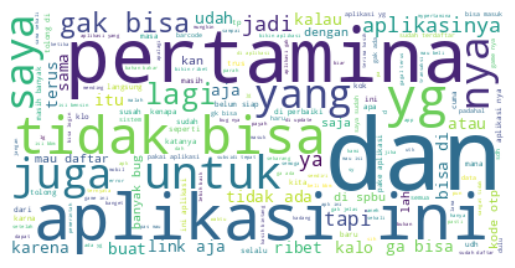

In [8]:
from wordcloud import WordCloud

text = " ".join(text for text in X_train)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [9]:
tf_idf_best_params = dict(
    ngram_range= (1, 2),
    use_idf= False,
    max_features= None,
    sublinear_tf= False
)

xgb_best_params = dict(
    learning_rate= 0.08659961156817399,
    max_depth= 8,
    n_estimators= 600,
    subsample= 0.763150470877663,
    colsample_bytree= 0.5939964783208691,
    gamma= 2.4559180064649005e-09
)

vectorizer = TfidfVectorizer(**tf_idf_best_params)

classifier = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    **xgb_best_params
)

pipeline = Pipeline([
    ('Feature Extractor Tfidf', vectorizer),
    ('Classifier', classifier)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('Feature Extractor Tfidf',
                 TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
                ('Classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.5939964783208691, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, g...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.08659961156817399, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=600,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [10]:
joblib.dump(le, 'label_encoder.joblib')
joblib.dump(pipeline, 'xgb_sentiment_analysis_pipeline.joblib')

['xgb_sentiment_analysis_pipeline.joblib']

uncomment kode dibawah untuk melakukan hyperparameter tuning, seed sudah diatur sehingga hasil tetap konsisten, optimal pada iterasi ke 48.

In [11]:
# def objective(trial):
#     # Parameter space untuk TfidfVectorizer
#     ngram_range = trial.suggest_categorical('ngram_range', [(1,1), (1,2)])
#     max_features = trial.suggest_categorical('max_features', [None, 1000, 2000, 3000, 4000, 5000])
#     use_idf = trial.suggest_categorical('use_idf', [True, False])
#     sublinear_tf = trial.suggest_categorical('sublinear_tf', [True, False])
    
#     # Parameter space untuk XGBClassifier
#     learning_rate = trial.suggest_float('learning_rate', 1e-3, 0.3, log=True)
#     max_depth = trial.suggest_int('max_depth', 3, 10)
#     n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
#     subsample = trial.suggest_float('subsample', 0.5, 1.0)
#     colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
#     gamma = trial.suggest_float('gamma', 1e-9, 1.0, log=True)
    
#     # Membuat pipeline dengan parameter yang diuji
#     vectorizer = TfidfVectorizer(
#         ngram_range=ngram_range,
#         max_features=max_features,
#         use_idf=use_idf,
#         sublinear_tf=sublinear_tf
#     )
    
#     classifier = XGBClassifier(
#         learning_rate=learning_rate,
#         max_depth=max_depth,
#         n_estimators=n_estimators,
#         subsample=subsample,
#         colsample_bytree=colsample_bytree,
#         gamma=gamma,
#         random_state=42,
#         use_label_encoder=False,
#         eval_metric='logloss'
#     )
    
#     pipeline = Pipeline([
#         ('Feature Extractor Tfidf', vectorizer),
#         ('Classifier', classifier)
#     ])

#     pipeline.fit(X_train, y_train)
    
#     return pipeline.score(X_test, y_test)

# # Membuat study Optuna
# study = optuna.create_study(
#     direction='maximize',
#     sampler=TPESampler(seed=42))
# study.optimize(objective, n_trials=100)

# # Menampilkan hasil terbaik
# print("Best trial:")
# trial = study.best_trial

# print(f"  Value (Accuracy): {trial.value:.5f}")
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

## Proses Evaluasi

In [12]:
print(classification_report(y_train, pipeline.predict(X_train)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17809
           1       1.00      0.94      0.97       427
           2       0.98      0.89      0.93      5764

    accuracy                           0.97     24000
   macro avg       0.98      0.94      0.96     24000
weighted avg       0.97      0.97      0.97     24000



In [13]:
print(classification_report(y_test, pipeline.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4452
           1       0.26      0.06      0.09       107
           2       0.79      0.59      0.68      1441

    accuracy                           0.85      6000
   macro avg       0.64      0.53      0.56      6000
weighted avg       0.83      0.85      0.83      6000



# Skema 2

model: finetuning huggingface "lxyuan/distilbert-base-multilingual-cased-sentiments-student"  
feature_extractor = "default tokenizer"   
train_test_split = 0.8 train/0.2 test/random_state=42/stratify y 

In [14]:
features = Features({
    'content': Value('string'),
    'label': ClassLabel(num_classes=3, names=df['label'].unique().tolist()),
})

data = Dataset.from_pandas(df, features=features)
data = data.train_test_split(test_size=0.2, seed=42, stratify_by_column='label')

In [15]:
def evaluate_with_huggingface_metrics(model, dataloader, accelerator):
    model.eval()
    metric = load("accuracy")  # Muat metrik akurasi
    
    for batch in dataloader:
        with torch.no_grad():
            outputs = model(**batch)
        
        # Ambil prediksi dan label
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        labels = batch["labels"]
        
        # Kumpulkan prediksi dan label dari semua proses (jika distributed)
        predictions, labels = accelerator.gather_for_metrics(
            (predictions, labels))
        
        # Update metrik
        metric.add_batch(predictions=predictions, references=labels)
    
    # Hitung akurasi akhir
    accuracy = metric.compute()["accuracy"]
    return accuracy

In [16]:
def training_function():
    checkpoint = 'mdhugol/indonesia-bert-sentiment-classification'
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    
    # Tokenisasi dataset
    def tokenize_function(example):
        return tokenizer(example['content'], truncation=True, padding="max_length")
    
    tokenized_datasets = data.map(tokenize_function, batched=True)
    tokenized_datasets = tokenized_datasets.remove_columns(['content'])
    tokenized_datasets = tokenized_datasets.rename_column('label', 'labels')
    tokenized_datasets.set_format('torch')
    
    # Siapkan DataLoader
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    train_dataloader = DataLoader(
        tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
    )
    test_dataloader = DataLoader(
        tokenized_datasets["test"], batch_size=8, collate_fn=data_collator
    )
    
    # Inisialisasi model, optimizer, dan accelerator
    accelerator = Accelerator()
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
    optimizer = AdamW(model.parameters(), lr=3e-5)
    
    # Siapkan komponen untuk distributed training
    train_dataloader, test_dataloader, model, optimizer = accelerator.prepare(
        train_dataloader, test_dataloader, model, optimizer
    )
    
    num_epochs = 3
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        for batch in train_dataloader:
            outputs = model(**batch)
            loss = outputs.loss
            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad()
        
        # Evaluasi dengan Hugging Face Metrics
        train_accuracy = evaluate_with_huggingface_metrics(model, train_dataloader, accelerator)
        test_accuracy = evaluate_with_huggingface_metrics(model, test_dataloader, accelerator)
        
        accelerator.print(f"\nEpoch {epoch + 1}")
        accelerator.print(f"Train Accuracy: {train_accuracy:.4f}")
        accelerator.print(f"Test Accuracy: {test_accuracy:.4f}")

# Jalankan training loop dengan notebook_launcher
notebook_launcher(training_function, num_processes=1)

Launching training on one GPU.


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]


Epoch 1
Train Accuracy: 0.9015
Test Accuracy: 0.8648

Epoch 2
Train Accuracy: 0.9307
Test Accuracy: 0.8795

Epoch 3
Train Accuracy: 0.9635
Test Accuracy: 0.8747
